In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Load from file 
dataset = pd.read_csv("data/Crimes_-_2001_to_Present_20250314.csv")

In [3]:
# Preprocessing date and texts
dataset['Date'] = pd.to_datetime(dataset['Date'], format='%m/%d/%Y %I:%M:%S %p', errors='coerce')
dataset['Primary Type'] = dataset['Primary Type'].str.upper()  
dataset['Location Description'] = dataset['Location Description'].str.upper()

# Remove duplicates
dataset = dataset.drop_duplicates()

# Filter data: exclude those without latitude
dataset = dataset[~dataset["Latitude"].isna()]

# exclude those in "rare locations" (< 20 occurrences, will make location processing simpler)
rare_locations = dataset.groupby("Location Description").filter(lambda x: len(x) < 20)["Location Description"].tolist()
dataset = dataset[~dataset["Location Description"].isin(rare_locations)]

In [4]:
pd.set_option('display.max_columns', None)
dataset.head()

,ID,Case Number,Date,Block,IUCR,Primary Type,Description,Location Description,Arrest,Domestic,Beat,District,Ward,Community Area,FBI Code,X Coordinate,Y Coordinate,Year,Updated On,Latitude,Longitude,Location
3,13203321,JG415333,2023-09-06 17:00:00,002XX N Wells st,1320,CRIMINAL DAMAGE,TO VEHICLE,PARKING LOT / GARAGE (NON RESIDENTIAL),False,False,122,1.0,42.0,32.0,14,1174694.0,1901831.0,2023,11/04/2023 03:40:18 PM,41.886018,-87.633938,"(41.886018055, -87.633937881)"
4,13204489,JG416325,2023-09-06 11:00:00,0000X E 8TH ST,0810,THEFT,OVER $500,PARKING LOT / GARAGE (NON RESIDENTIAL),False,False,123,1.0,4.0,32.0,06,1176857.0,1896680.0,2023,11/04/2023 03:40:18 PM,41.871835,-87.626151,"(41.871834768, -87.62615082)"
5,11695116,JC272771,2019-05-21 08:20:00,018XX S CALIFORNIA AVE,0620,BURGLARY,UNLAWFUL ENTRY,RESIDENCE,False,False,1023,10.0,25.0,29.0,05,1157982.0,1890961.0,2019,01/19/2024 03:40:50 PM,41.856547,-87.695605,"(41.856547057, -87.695604526)"
6,12419690,JE295655,2021-07-07 10:30:00,132XX S GREENWOOD AVE,1544,SEX OFFENSE,SEXUAL EXPLOITATION OF A CHILD,RESIDENCE,False,False,533,5.0,10.0,54.0,17,1186051.0,1817781.0,2021,01/19/2024 03:40:50 PM,41.655116,-87.594883,"(41.65511579, -87.594883198)"
7,12729745,JF279458,2022-06-14 14:47:00,035XX N CENTRAL AVE,0340,ROBBERY,ATTEMPT STRONG ARM - NO WEAPON,BANK,True,False,1633,16.0,30.0,15.0,03,1138391.0,1923142.0,2022,01/19/2024 03:40:50 PM,41.945232,-87.766735,"(41.945232412, -87.766734668)"


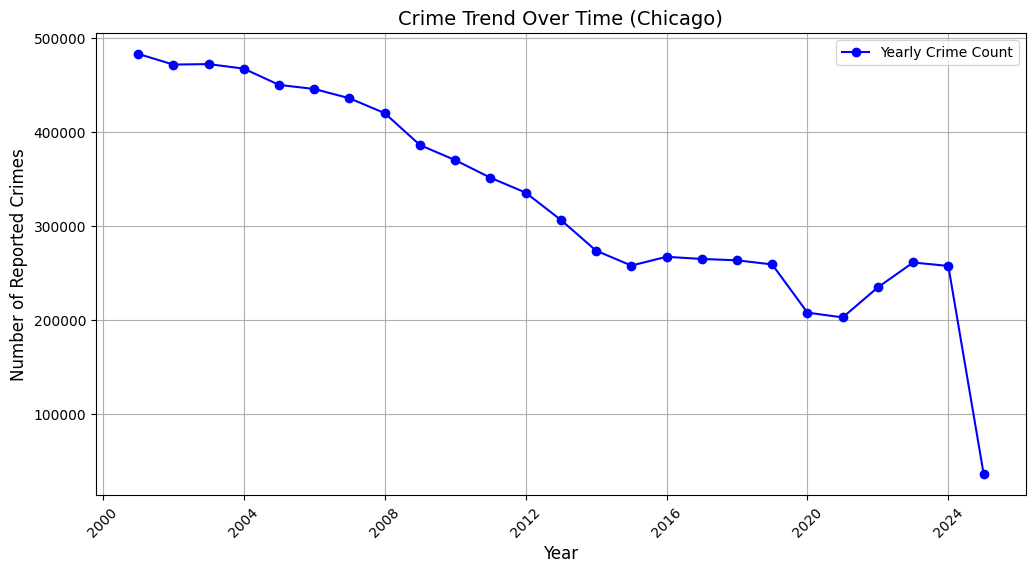

In [5]:
# Extract year
crimes_by_year = dataset["Date"].dt.to_period("Y")  # "Y" for yearly
crime_trend_yearly = crimes_by_year.value_counts().sort_index()

# Remove the last element (2025, not complete)
crime_trend_yearly.index = crime_trend_yearly.index.to_timestamp()

# Plot the yearly crime trend
plt.figure(figsize=(12, 6))
plt.plot(crime_trend_yearly, marker="o", linestyle="-", color="blue", label="Yearly Crime Count")
plt.title("Crime Trend Over Time (Chicago)", fontsize=14)
plt.xlabel("Year", fontsize=12)
plt.ylabel("Number of Reported Crimes", fontsize=12)
plt.xticks(rotation=45)
plt.grid(True)
plt.legend()
plt.show()

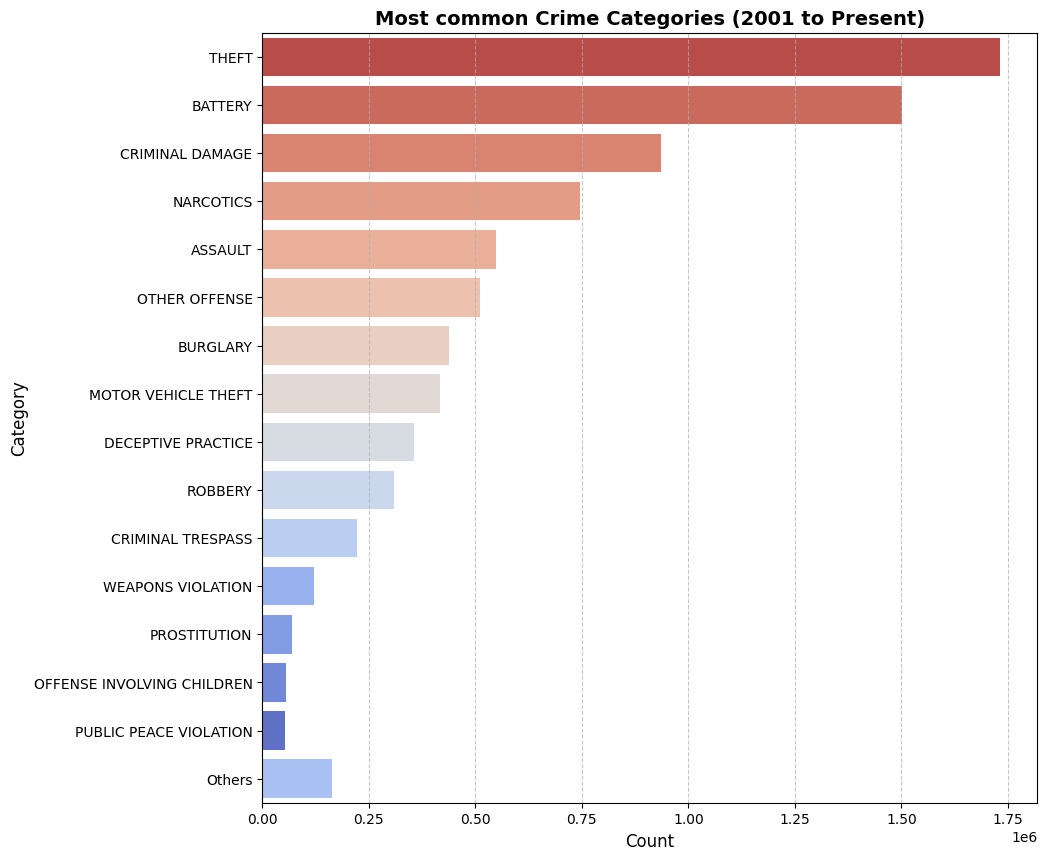

In [6]:
import seaborn as sns

# Group by Primary Type and count occurrences
crime_counts = dataset["Primary Type"].value_counts()

# Optional: Show only top 10 crime types for readability
top_crimes = crime_counts[:15]
top_crimes["Others"] = crime_counts[15:].sum()

category_order = top_crimes.index


# Create the sorted horizontal count plot with the correct method
plt.figure(figsize=(10, 10))
ax = sns.barplot(
    x=top_crimes.values, 
    y=top_crimes.index, 
    order=category_order,
    hue=top_crimes.values,
    orient="h",
    legend=False, 
    palette=sns.color_palette("coolwarm", len(category_order))
)

# Add grid for better readability
plt.grid(axis='x', linestyle='--', alpha=0.7)

# Improve labels and title
plt.xlabel('Count', fontsize=12)
plt.ylabel('Category', fontsize=12)
plt.title('Most common Crime Categories (2001 to Present)', fontsize=14, fontweight='bold')

# Show the plot
plt.show()

In [7]:
# We are interested in
CRIME_CATEGORIES = {
    "ASSAULT": [
        "BATTERY",
        "ASSAULT", 
        "ROBBERY", 
        "WEAPONS VIOLATION", 
        "HOMICIDE", 
        "INTIMIDATION"
    ],
    
    "SEX OFFENSE": [
        "SEX OFFENSE", 
        "CRIM SEXUAL ASSAULT", 
        "KIDNAPPING", 
        "CRIMINAL SEXUAL ASSAULT", 
        "STALKING"
    ],

    "THEFT": [
        "THEFT", 
        "CRIMINAL DAMAGE",  
        "MOTOR VEHICLE THEFT"
    ],

    "MINOR": [
        "NARCOTICS",
        "BURGLARY",
        "PROSTITUTION",
        "PUBLIC PEACE VIOLATION",
        "OBSCENITY",
        "PUBLIC INDECENCY",
        "ARSON"
    ],

    "NON STREET CRIME": [
        "OTHER OFFENSE",
        "DECEPTIVE PRACTICE",
        "CRIMINAL TRESPASS",
        "OFFENSE INVOLVING CHILDREN",
        "CONCEALED CARRY LICENSE VIOLATION",
        "NON-CRIMINAL",
        "OTHER NARCOTIC VIOLATION",
        "HUMAN TRAFFICKING",
        "NON - CRIMINAL",
        "RITUALISM",
        "NON-CRIMINAL (SUBJECT SPECIFIED)",
        "DOMESTIC VIOLENCE"
    ]
}

In [8]:
# Set crime macro-category
dataset["Category"] = None
for category, crime_list in CRIME_CATEGORIES.items():
    dataset.loc[dataset["Primary Type"].isin(crime_list), "Category"] = category

In [9]:
dataset.Category.value_counts(dropna=False)

Category
THEFT               3085635
ASSAULT             2497611
MINOR               1322682
NON STREET CRIME    1146785
SEX OFFENSE           79374
None                  49257
Name: count, dtype: int64

## Crime location preprocessing

In [10]:
# Public transport-related locations
PUBLIC_TRANSPORTS = [
    'CTA BUS STOP',
    'VEHICLE NON-COMMERCIAL',
    'TAXICAB',
    'CTA BUS',
    'VEHICLE-COMMERCIAL',
    'CTA PLATFORM',
    'CTA TRAIN',
    'VEHICLE - DELIVERY TRUCK',
    'CTA TRACKS - RIGHT OF WAY',
    'OTHER COMMERCIAL TRANSPORTATION',
    'CTA STATION',
    'VEHICLE - OTHER RIDE SHARE SERVICE (E.G., UBER, LYFT)',
    'VEHICLE - COMMERCIAL',
    'CTA GARAGE / OTHER PROPERTY',
    'VEHICLE - OTHER RIDE SHARE SERVICE (E.G., LYFT, UBER, ETC.)',
    'CTA PARKING LOT / GARAGE / OTHER PROPERTY',
    'VEHICLE - OTHER RIDE SHARE SERVICE (LYFT, UBER, ETC.)',
    'VEHICLE - OTHER RIDE SERVICE',
]

AIRPORT = [
    'AIRPORT TERMINAL LOWER LEVEL - NON-SECURE AREA',
    'AIRPORT TERMINAL UPPER LEVEL - NON-SECURE AREA',
    'AIRPORT TERMINAL LOWER LEVEL - SECURE AREA',
    'AIRPORT TRANSPORTATION SYSTEM (ATS)',
    'AIRPORT EXTERIOR - SECURE AREA',
    'AIRPORT TERMINAL MEZZANINE - NON-SECURE AREA',
    'AIRPORT EXTERIOR - NON-SECURE AREA',
    'AIRPORT BUILDING NON-TERMINAL - SECURE AREA',
    'AIRPORT TERMINAL UPPER LEVEL - SECURE AREA',
    'AIRPORT/AIRCRAFT'
]



STORES = [
    'SMALL RETAIL STORE',
    'CAR WASH',
    'CLEANING STORE',
    'GROCERY FOOD STORE',
    'TAVERN / LIQUOR STORE',
    'MOVIE HOUSE / THEATER',
    'RESTAURANT',
    'CONVENIENCE STORE',
    'SPORTS ARENA / STADIUM',
    'RETAIL STORE',
    'DEPARTMENT STORE',
    'COMMERCIAL / BUSINESS OFFICE',
    'FACTORY/MANUFACTURING BUILDING',
    'BAR OR TAVERN',
    'BARBER SHOP/BEAUTY SALON'
]

# Street-related locations
STREET = [
    'SCHOOL, PRIVATE, GROUNDS',
    'VACANT LOT/LAND',
    'ALLEY',
    'COLLEGE / UNIVERSITY GROUNDS',
    'AIRPORT EXTERIOR - SECURE AREA',
    'HIGHWAY/EXPRESSWAY',
    'FOREST PRESERVE',
    'PARKING LOT',
    'PARKING LOT / GARAGE (NON RESIDENTIAL)',
    'SCHOOL, PUBLIC, BUILDING',
    'SCHOOL - PRIVATE GROUNDS',
    'PARKING LOT/GARAGE(NON.RESID.)',
    'NEWSSTAND',
    'LAKEFRONT/WATERFRONT/RIVERBANK',
    'BRIDGE',
    'HOSPITAL BUILDING/GROUNDS',
    'COLLEGE / UNIVERSITY - GROUNDS',
    'VACANT LOT',
    'HIGHWAY / EXPRESSWAY',
    'OTHER (SPECIFY)',
    'POLICE FACILITY/VEH PARKING LOT',
    'CHA PARKING LOT/GROUNDS',
    'PARK PROPERTY',
    'OTHER RAILROAD PROP / TRAIN DEPOT',
    'VEHICLE - DELIVERY TRUCK',
    'PARKING LOT / GARAGE(NON.RESID.)',
    'BANK',
    'SIDEWALK',
    'LAKEFRONT / WATERFRONT / RIVERBANK',
    'POLICE FACILITY / VEHICLE PARKING LOT',
    'STREET',
    'VACANT LOT / LAND',
    'CEMETARY',
    'SCHOOL - PUBLIC BUILDING',
    'GAS STATION',
    'ATM (AUTOMATIC TELLER MACHINE)',
    'SCHOOL, PUBLIC, GROUNDS',
    'DELIVERY TRUCK'
]

# Private locations
PRIVATE = [  
    'COLLEGE / UNIVERSITY - RESIDENCE HALL',
    'HALLWAY',
    'CASINO/GAMBLING ESTABLISHMENT',
    'CHA HALLWAY',
    'YARD',
    'AUTO / BOAT / RV DEALERSHIP',
    'CHURCH / SYNAGOGUE / PLACE OF WORSHIP',
    'SAVINGS AND LOAN',
    'RESIDENCE - PORCH / HALLWAY',
    'FEDERAL BUILDING',
    'MEDICAL / DENTAL OFFICE',
    'BOAT/WATERCRAFT',
    'FIRE STATION',
    'RESIDENCE-GARAGE',
    'JAIL / LOCK-UP FACILITY',
    'SPORTS ARENA/STADIUM',
    'COIN OPERATED MACHINE',
    'DRIVEWAY',
    'BARBER SHOP / BEAUTY SALON',
    'HOUSE',
    'MOVIE HOUSE/THEATER',
    'HOTEL/MOTEL',
    'SCHOOL - PRIVATE BUILDING',
    'CHURCH/SYNAGOGUE/PLACE OF WORSHIP',
    'SCHOOL - PUBLIC GROUNDS',
    'HOTEL / MOTEL',
    'BOWLING ALLEY',
    'RESIDENCE - GARAGE',
    'CREDIT UNION',
    'COLLEGE/UNIVERSITY RESIDENCE HALL',
    'GOVERNMENT BUILDING/PROPERTY',
    'DAY CARE CENTER',
    'HOSPITAL BUILDING / GROUNDS',
    'HOTEL',
    'AIRCRAFT',
    'AIRPORT BUILDING NON-TERMINAL - NON-SECURE AREA',
    'MEDICAL/DENTAL OFFICE',
    'POOL ROOM',
    'APPLIANCE STORE',
    'VESTIBULE',
    'NURSING HOME/RETIREMENT HOME',
    'BASEMENT',
    'SPORTS ARENA / STADIUM',
    'PORCH',
    'AUTO',
    'ABANDONED BUILDING',
    'NURSING / RETIREMENT HOME',
    'TAVERN',
    'CHA PARKING LOT / GROUNDS',
    'VACANT LOT / LAND',
    'ANIMAL HOSPITAL',
    'GARAGE',
    'OTHER RAILROAD PROPERTY / TRAIN DEPOT',
    'CONSTRUCTION SITE',
    'STAIRWELL',
    'RESIDENCE - YARD (FRONT / BACK)',
    'COLLEGE/UNIVERSITY GROUNDS',
    'SCHOOL, PRIVATE, BUILDING',
    'AIRPORT PARKING LOT',
    'RESIDENCE',
    'FACTORY / MANUFACTURING BUILDING',
    'PAWN SHOP',
    'RESIDENCE PORCH/HALLWAY',
    'DRIVEWAY - RESIDENTIAL',
    'GOVERNMENT BUILDING / PROPERTY',
    'AIRPORT VENDING ESTABLISHMENT',
    'BOAT / WATERCRAFT',
    'CHA GROUNDS',
    'GAS STATION DRIVE/PROP.',
    'COLLEGE / UNIVERSITY RESIDENCE HALL',
    'DRUG STORE',
    'CHA HALLWAY/STAIRWELL/ELEVATOR',
    'CHA PARKING LOT',
    'RESIDENTIAL YARD (FRONT/BACK)',
    'TAVERN/LIQUOR STORE',
    'CHA APARTMENT',
    'OTHER',
    'CURRENCY EXCHANGE',
    'SCHOOL - PRIVATE GROUNDS',
    'TAVERN / LIQUOR STORE',
    'OFFICE',
    'CASINO / GAMBLING ESTABLISHMENT',
    'WAREHOUSE',
    'BARBERSHOP',
    'GANGWAY',
    'CHA HALLWAY / STAIRWELL / ELEVATOR',
    'APARTMENT',
    'LIBRARY',
    'ATHLETIC CLUB',
    'CHA HALLWAY''AUTO / BOAT / RV DEALERSHIP',
]

In [15]:
dataset["Location Category"] = None
dataset.loc[dataset["Location Description"].isin(PUBLIC_TRANSPORTS), "Location Category"] = "Public Transports"
dataset.loc[dataset["Location Description"].isin(STREET), "Location Category"] = "Street"
dataset.loc[dataset["Location Description"].isin(AIRPORT), "Location Category"] = "Airport"
dataset.loc[dataset["Location Description"].isin(STORES), "Location Category"] = "Stores"
dataset.loc[dataset["Location Description"].isin(PRIVATE), "Location Category"] = "Non concerning"
dataset["Location Category"].value_counts()

Location Category
Street               3856340
Non concerning       3344548
Stores                665939
Public Transports     276294
Airport                29160
Name: count, dtype: int64

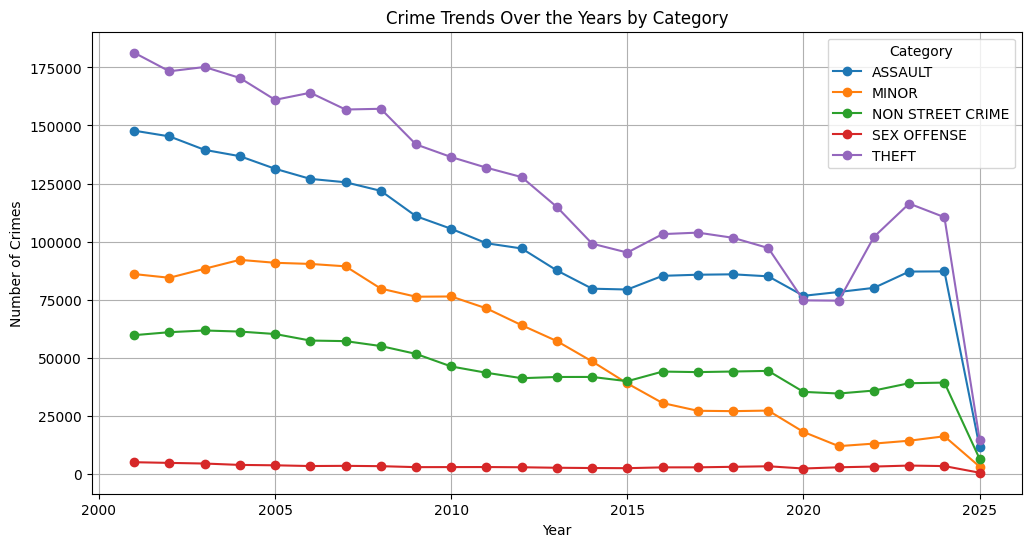

In [16]:
# Load the dataset
dataset["Year"] = dataset["Date"].dt.year

# Group by year and category, then count occurrences
crime_trends = dataset.groupby(["Year", "Category"]).size().unstack()
crime_trends.plot(marker='o', figsize=(12, 6))

plt.xlabel("Year")
plt.ylabel("Number of Crimes")
plt.title("Crime Trends Over the Years by Category")
plt.legend(title="Category")
plt.grid(True)

plt.show()

<Figure size 1200x600 with 0 Axes>

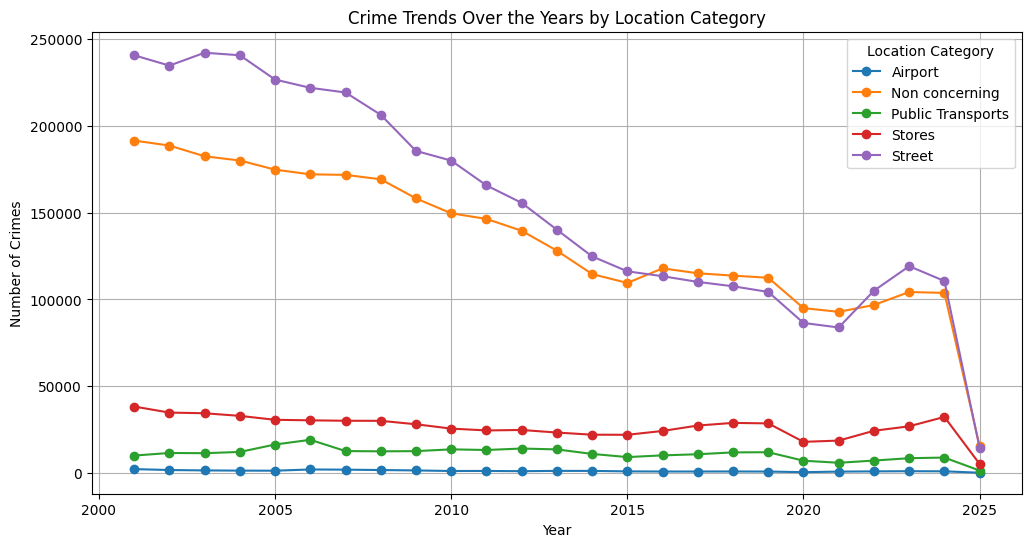

In [17]:
# Load the dataset
dataset["Year"] = dataset["Date"].dt.year

# Group by year and category, then count occurrences
crime_trends = dataset.groupby(["Year", "Location Category"]).size().unstack()
plt.figure(figsize=(12, 6))
crime_trends.plot(marker='o', figsize=(12, 6))

plt.xlabel("Year")
plt.ylabel("Number of Crimes")
plt.title("Crime Trends Over the Years by Location Category")
plt.legend(title="Location Category")
plt.grid(True)

plt.show()


In [18]:
# Now remove non concerning crimes
dataset = dataset[dataset["Category"] != 'NON STREET CRIME']
dataset = dataset[dataset["Location Category"] != 'Non concerning']

In [19]:
# Required libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from ipywidgets import interact, widgets
import matplotlib.dates as mdates

# Extract hour from date
dataset['hour'] = dataset['Date'].dt.hour

# Create the interactive function
def plot_crime_time_distribution(type, location):
    # Filter data by selected crime type
    filtered_df = dataset[(dataset['Category'] == type) & (dataset["Location Category"] == location)] 
    
    # Plotting the distribution of crime time
    plt.figure(figsize=(10, 6))
    sns.histplot(filtered_df['hour'], bins=24, kde=False, color='blue', edgecolor='black')
    
    # Customizing the plot
    plt.title(f'Crime Time Distribution for SEX OFFENSE')
    plt.xlabel('Hour of the Day')
    plt.ylabel('Count of Crimes')
    plt.xticks(range(24), [f'{i}:00' for i in range(24)], rotation=45)
    plt.grid(True, linestyle='--', alpha=0.7)
    
    # Show plot
    plt.tight_layout()
    plt.show()


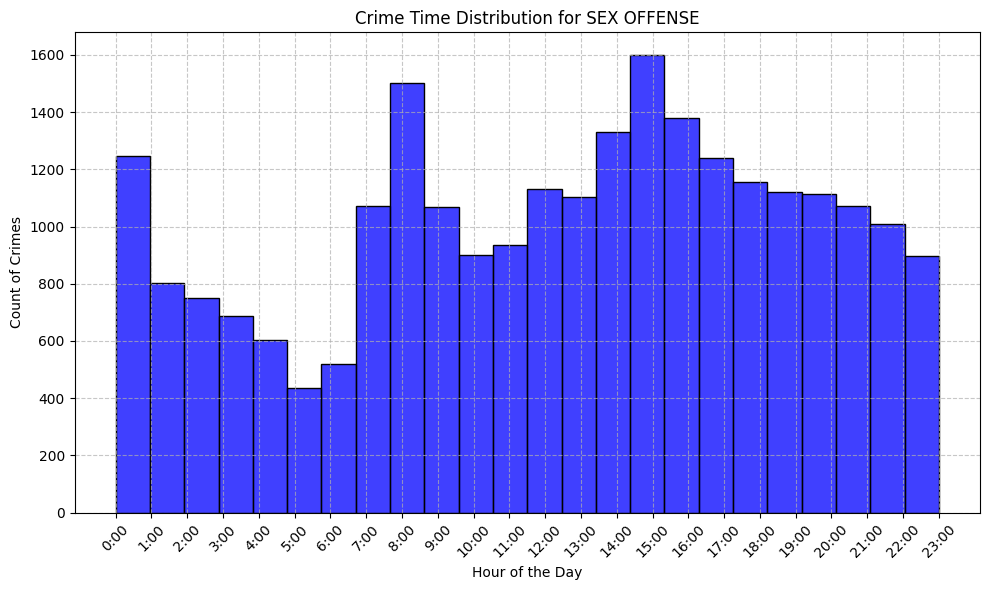

In [20]:
from typing import Tuple


plot_crime_time_distribution("SEX OFFENSE", "Street")

def get_slice(category: str, location: str, hour_range: Tuple[int, int]):
    return dataset[(dataset['Category'] == category) 
                   & (dataset["Location Category"] == location)
                   & (hour_range[0] <= dataset["hour"])
                   & (hour_range[1] > dataset["hour"])]

In [21]:
!pip install folium
import folium
from folium.plugins import HeatMap


In [22]:
import folium
from folium.plugins import HeatMap

# Create a folium map centered around Chicago
chicago_map = folium.Map(location=[41.8781, -87.6298], zoom_start=12)

# Function to get the crime data slice (assuming you have this function)
crimes_selected = get_slice("SEX OFFENSE", "Street", (0, 3))
crimes_selected = pd.concat([crimes_selected, get_slice("ASSAULT", "Street", (0, 3))])


# Prepare the data for HeatMap
heat_data = [[row['Latitude'], row['Longitude']] for _, row in crimes_selected.iterrows() if row["Latitude"] is not None]

# Add the HeatMap layer
heatmap = HeatMap(
    heat_data,
    min_opacity=0.2,  
    radius=60,        
    blur=15, 
    max_zoom=40,      
).add_to(chicago_map)

# Add pinpoint markers for Loyola University Chicago and The Shops at North Bridge
locations = [
    {"name": "Loyola University Chicago", "lat": 42.0010, "lon": -87.6606, "color": "blue"},
    {"name": "The Shops at North Bridge", "lat": 41.8917, "lon": -87.6240, "color": "red"}
]

# Add markers to the map
for loc in locations:
    folium.Marker(
        location=[loc["lat"], loc["lon"]],
        popup=loc["name"],  # Clickable label
        icon=folium.Icon(color=loc["color"], icon="info-sign")  # Customize icon
    ).add_to(chicago_map)

# Save the map as an HTML file
chicago_map.save("crime_selected_density_map.html")
